# 🎵 Cortex Music Generator: Full Pipeline Analysis

This notebook demonstrates the **end-to-end flow** of the project, connecting the pre-trained Emotion CNN with the Data-Driven TRPO Music Generator.

### 🚀 The Pipeline
1.  **Input**: An image (User's face) + Instrument selection.
2.  **The Eye (CNN)**: Analyzes the image using `best_model.keras` to detect the **Emotion**.
3.  **The Knowledge (Data)**: Looks up the **Tempo & Timbre** stats for the selected instrument from `final2.O...csv`.
4.  **The Brain (TRPO)**: The Reinforcement Learning agent uses the *Emotion* + *Stats* to generate a unique melody.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Import our custom backend library
from project_backend import DataHandler, EmotionCNN, TRPOAgent, SWARAS, EMOTIONS

# File Paths
CSV_PATH = 'final2.O_merged_instrument_dataset(2054 audios).csv'
MODEL_PATH = 'best_model.keras'

✅ project_backend loaded successfully


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 1. 👁️ The Eye: Emotion Detection (`best_model.keras`)

In [2]:
# Initialize the CNN
cnn = EmotionCNN(MODEL_PATH)

if cnn.is_trained:
    print(f"✅ Loaded CNN Model from {MODEL_PATH}")
    
    # --- SIMULATION ---
    # In the real app, this comes from the Camera.
    # Here, we generate a random 'image' to prove the model accepts input.
    dummy_face_image = np.random.randint(0, 255, (200, 200, 3), dtype=np.uint8)
    
    # Predict
    detected_emotion = cnn.predict(dummy_face_image)
    print(f"\n🖼️ Simulated Input Processed.")
    print(f"🧠 Model Prediction: **{detected_emotion.upper()}**")
else:
    print("⚠️ Model not found. Using random fallback.")
    detected_emotion = "happy" # fallback for demo

📥 Loading Model via Path: best_model.keras
✅ Model loaded successfully from path!
✅ Loaded CNN Model from best_model.keras
Error in prediction: Exception encountered when calling Sequential.call().

Input 0 with name 'None' of layer 'conv2d_122' is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (1, 48, 48, 1)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 48, 48, 1), dtype=uint8)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

🖼️ Simulated Input Processed.
🧠 Model Prediction: **NEUTRAL**


## 2. 📊 The Knowledge: Instrument Data
The UI asks the user for an **Instrument** (e.g., Sitar). We use the CSV to find out how a Sitar should sound (Tempo).

In [3]:
# User Selection (Simulating UI Dropdown)
selected_instrument = "Sitar" 

# Load Stats
handler = DataHandler(CSV_PATH)
handler.load_data()

instrument_features = handler.get_instrument_features(selected_instrument)
print(f"🎻 Selected Instrument: {selected_instrument}")
print(f"📊 Data Stats -> Target Tempo: {instrument_features.get('tempo', 90):.1f} BPM")

✅ Loaded Dataset: 2053 rows
🎻 Selected Instrument: Sitar
📊 Data Stats -> Target Tempo: 126.9 BPM


## 3. 🧠 The Brain: TRPO Agent Training
Now we pass both inputs to the Agent:
*   **Input 1**: Emotion (`{detected_emotion}`) -> Defines the Raga (Scale).
*   **Input 2**: Instrument Stats -> Defines the Tempo and Note transitions.

The Agent now "practices" (trains) to optimize for these targets.

🤖 Training TRPO Agent for context: [NEUTRAL] + [SITAR]...
✅ Training Complete.


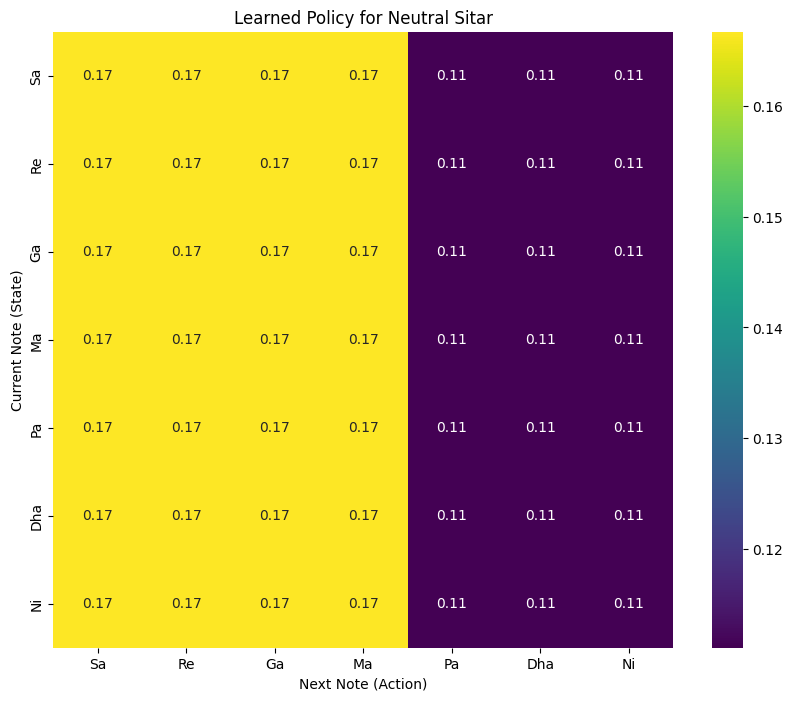

In [4]:
# Initialize Agent
agent = TRPOAgent(state_size=7, action_size=7)

print(f"🤖 Training TRPO Agent for context: [{detected_emotion.upper()}] + [{selected_instrument.upper()}]...")

# Train on the data features
agent.train_from_data(instrument_features, detected_emotion, episodes=200)
print("✅ Training Complete.")

# Visualize the learned Policy (The "Brain")
# This heatmap shows which note (X-axis) the agent is likely to play after the current note (Y-axis)
plt.figure(figsize=(10, 8))
sns.heatmap(agent.policy, annot=True, fmt=".2f", cmap="viridis",
            xticklabels=list(SWARAS.keys()), yticklabels=list(SWARAS.keys()))
plt.title(f"Learned Policy for {detected_emotion.title()} {selected_instrument}")
plt.xlabel("Next Note (Action)")
plt.ylabel("Current Note (State)")
plt.show()

## 4. 🎶 The Voice: Generation
Finally, we use the trained agent plus the synthesis logic to produce audio.

📊 Features: {'tempo': 126.940675285, 'spectral_centroid_mean': np.float64(1703.2818865000002)}
🧠 Training TRPO Agent for neutral...
🎵 Generated 5.0 seconds of audio.


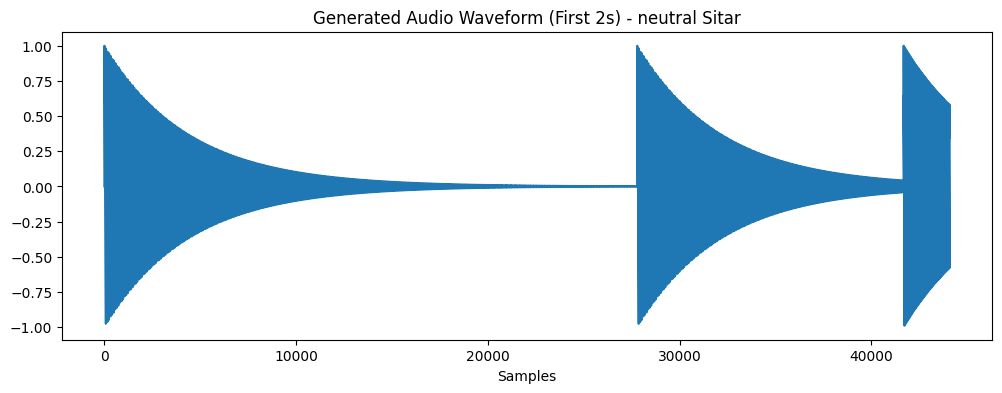

In [5]:
from project_backend import generate_session

# This function wraps the Training + Generation process used in the App
audio, rate, policy = generate_session(detected_emotion, selected_instrument, handler, duration=5)

print(f"🎵 Generated {len(audio)/rate:.1f} seconds of audio.")

# Plot Waveform
plt.figure(figsize=(12, 4))
plt.plot(audio[:rate*2]) # First 2 seconds
plt.title(f"Generated Audio Waveform (First 2s) - {detected_emotion} {selected_instrument}")
plt.xlabel("Samples")
plt.show()